# causalBootstrapping: Tutorial 02

A series of tutorials demonstrating the use of the causalBootstrapping library.

### Frontdoor

This tutorial mainly focuses on illustrating the use of frontdoor causal bootstrapping interfaces: `frontdoor_simple()` and `frontdoor_simu()`.

In [1]:
import causalBootstrapping as cb
from distEst_lib import MultivarContiDistributionEstimator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import classification_report

#### Usage example: frontdoor_simple()

In [2]:
# Read demo data
testdata_dir = "../test_data/frontdoor_discY_contZ_contX_discU/"
X_train = pd.read_csv(testdata_dir + "X_train.csv")
Y_train = pd.read_csv(testdata_dir + "Y_train.csv")
Z_train = pd.read_csv(testdata_dir + "Z_train.csv")

In [3]:
# Re-formulate the data
X_train = np.array(X_train)
Y_train = np.array(Y_train)
Z_train = np.array(Z_train)

cause_data = {"Y": Y_train}
mediator_data = {"Z": Z_train}
effect_data = {"X": X_train}

In [4]:
# Estimate the desired distributions
n_bins_yz = [0,20]
n_bins_y = [0]
joint_yz_data = np.concatenate((Y_train.reshape(-1,1), Z_train), axis = 1)

dist_estimator_yz = MultivarContiDistributionEstimator(data_fit=joint_yz_data, n_bins = n_bins_yz)
pdf_yz, pyz = dist_estimator_yz.fit_histogram()
dist_estimator_y = MultivarContiDistributionEstimator(data_fit=Y_train, n_bins = n_bins_y)
pdf_y, py = dist_estimator_y.fit_histogram()

In [5]:
# Construct the distribution mapping dict
dist_map = {"Y,Z": lambda Y, Z: pdf_yz([Y,Z]),
            "Y',Z": lambda Y_prime, Z: pdf_yz([Y_prime,Z]),
            "Y": lambda Y: pdf_y(Y),
            "Y'": lambda Y_prime: pdf_y(Y_prime)}

In [6]:
# bootstrap the dataset given the frontdoor scenario
cb_data = cb.frontdoor_simple(cause_data, mediator_data, effect_data, dist_map)

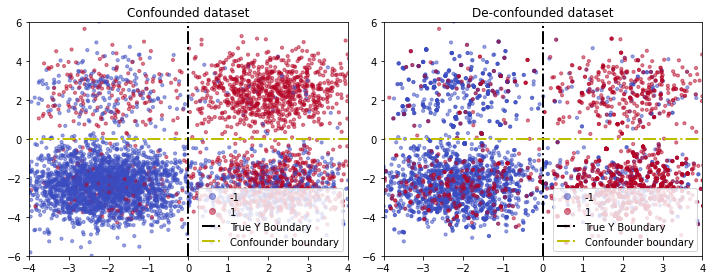

In [7]:
## Compare the boostrapping results with the original dataset
# The original confounded dataset
fig,axs=plt.subplots(1, 2 , figsize=(10,4))
scatter = axs[0].scatter(x= np.array(X_train)[:,0], y = np.array(X_train)[:,1], c = np.array(Y_train), s = 10, cmap='coolwarm', alpha = 0.5)
handles_scatter1, labels_scatter1 = scatter.legend_elements(prop="colors")

true_b1 = axs[0].plot([0, 0], [-6, 6], '-.k', linewidth=2, label="True boundary")
confounder1 = axs[0].plot([-6,6], [0,0], '-.y', linewidth = 2, label = "Confounder boundary")

axs[0].legend(handles=handles_scatter1+true_b1+confounder1, labels=['-1','1','True Y Boundary', 'Confounder boundary'], loc='lower right')
axs[0].set_xlim(-4,4)
axs[0].set_ylim(-6,6)
axs[0].set_title("Confounded dataset")

# The bootstrapped de-confounded dataset
scatter = axs[1].scatter(x= np.array(cb_data["X"])[:,0], y = np.array(cb_data["X"])[:,1], c = np.array(cb_data["intv_Y"]),  s = 10, cmap='coolwarm', alpha = 0.5)
handles_scatter2, labels_scatter2 = scatter.legend_elements(prop="colors")

true_b2 = axs[1].plot([0, 0], [-6, 6], '-.k', linewidth=2, label="True boundary")
confounder2 = axs[1].plot([-6,6], [0,0], '-.y', linewidth = 2, label = "Confounder boundary")

axs[1].legend(handles=handles_scatter2+true_b2+confounder2, labels=['-1','1','True Y Boundary', 'Confounder boundary'], loc='lower right')
axs[1].set_xlim(-4,4)
axs[1].set_ylim(-6,6)
axs[1].set_title("De-confounded dataset")

plt.tight_layout()
plt.show()

In [8]:
## Train two linear support vector machines using confounded and de-confounded datasets
clf_conf = svm.SVC(kernel = 'linear', C=5)
clf_conf.fit(X_train, Y_train.reshape(-1))

clf_cb = svm.SVC(kernel = 'linear', C=5)
clf_cb.fit(cb_data['X'], cb_data['intv_Y'].reshape(-1))

## compare their performance on un-confounded test set
X_test = pd.read_csv(testdata_dir +  "X_test.csv")
Y_test = pd.read_csv(testdata_dir +  "Y_test.csv")
X_test = np.array(X_test)
Y_test = np.array(Y_test)

y_pred_conf = clf_conf.predict(X_test)
print("Report of confonded model:")
print(classification_report(Y_test, y_pred_conf))

y_pred_deconf = clf_cb.predict(X_test)
print("Report of de-confonded model:")
print(classification_report(Y_test, y_pred_deconf))

Report of confonded model:
              precision    recall  f1-score   support

           1       0.63      0.80      0.71       386
           2       0.85      0.71      0.77       614

    accuracy                           0.74      1000
   macro avg       0.74      0.75      0.74      1000
weighted avg       0.77      0.74      0.75      1000

Report of de-confonded model:
              precision    recall  f1-score   support

           1       0.74      0.83      0.79       386
           2       0.89      0.82      0.85       614

    accuracy                           0.82      1000
   macro avg       0.81      0.83      0.82      1000
weighted avg       0.83      0.82      0.83      1000



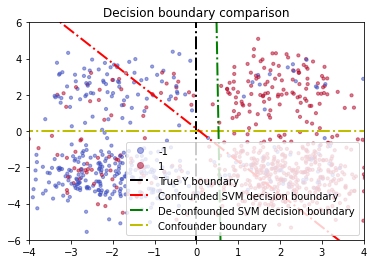

In [9]:
# Compare models' decision boundaries
weight_conf = clf_conf.coef_[0]
bias_conf = clf_conf.intercept_[0]
k_conf = -weight_conf[0] / weight_conf[1]
b_conf = -bias_conf / weight_conf[1]
x_conf = np.linspace(-4, 4, 100)
decison_boundary_conf = k_conf * x_conf + b_conf

weight_deconf = clf_cb.coef_[0]
bias_deconf = clf_cb.intercept_[0]
k_deconf = -weight_deconf[0] / weight_deconf[1]
b_deconf = -bias_deconf / weight_deconf[1]
x_deconf = np.linspace(-4, 4, 100)
decison_boundary_deconf = k_deconf * x_deconf + b_deconf

fig,ax=plt.subplots()
scatter = ax.scatter(x= X_test[:,0], y = X_test[:,1], c = Y_test, s = 10, cmap='coolwarm', alpha = 0.5)
handles_scatter, labels_scatter = scatter.legend_elements(prop="colors")

plt.xlim(-4,4)
plt.ylim(-6,6)
x_ = np.linspace(-4, 4, 100)

true_b = plt.plot([0, 0], [-6, 6], '-.k', linewidth=2, label="True boundary")
confounder = plt.plot([-6,6], [0,0], '-.y', linewidth = 2, label = "Confounder boundary")
clf_b_conf = plt.plot(x_, decison_boundary_conf, '-.r', linewidth = 2, label= 'Confounded SVM decision boundary')
clf_b_deconf = plt.plot(x_, decison_boundary_deconf, '-.g', linewidth = 2, label= 'De-confounded SVM decision boundary')

ax.legend(handles=handles_scatter+true_b+clf_b_conf+clf_b_deconf+confounder, labels=['-1','1','True Y boundary','Confounded SVM decision boundary', 'De-confounded SVM decision boundary', 'Confounder boundary'], loc='lower right')

plt.title('Decision boundary comparison')
plt.show()

#### Usage example: frontdoor_simu()

In [10]:
# Set simulated interventions and bootstrap the data
n_sample = 500
cb_data_simu_intv1 = cb.frontdoor_simu(cause_data = cause_data, mediator_data = mediator_data, effect_data = effect_data,
                                       dist_map = dist_map, intv_value = [1 for i in range(Y_train.shape[0])], n_sample = n_sample)
cb_data_simu_intv2 = cb.frontdoor_simu(cause_data = cause_data, mediator_data = mediator_data, effect_data = effect_data,
                                       dist_map = dist_map, intv_value = [2 for i in range(Y_train.shape[0])], n_sample = n_sample)
cb_data_simu = {}
for key in cb_data_simu_intv1.keys():
    cb_data_simu[key] = np.vstack((cb_data_simu_intv1[key], cb_data_simu_intv2[key]))

In [11]:
## Train two linear support vector machines using confounded and de-confounded datasets
clf_conf = svm.SVC(kernel = 'linear', C=5)
clf_conf.fit(X_train, Y_train.reshape(-1))

clf_cb = svm.SVC(kernel = 'linear', C=5)
clf_cb.fit(cb_data_simu['X'], cb_data_simu['intv_Y'].reshape(-1))

## compare their performance on un-confounded test set
y_pred_conf = clf_conf.predict(X_test)
print("Report of confonded model:")
print(classification_report(Y_test, y_pred_conf))

y_pred_deconf = clf_cb.predict(X_test)
print("Report of de-confonded model:")
print(classification_report(Y_test, y_pred_deconf))

Report of confonded model:
              precision    recall  f1-score   support

           1       0.63      0.80      0.71       386
           2       0.85      0.71      0.77       614

    accuracy                           0.74      1000
   macro avg       0.74      0.75      0.74      1000
weighted avg       0.77      0.74      0.75      1000

Report of de-confonded model:
              precision    recall  f1-score   support

           1       0.77      0.82      0.80       386
           2       0.88      0.85      0.87       614

    accuracy                           0.84      1000
   macro avg       0.83      0.84      0.83      1000
weighted avg       0.84      0.84      0.84      1000



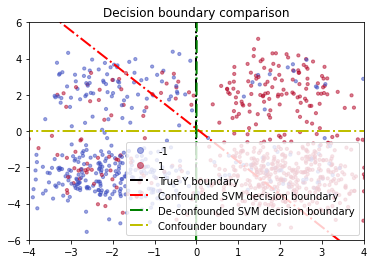

In [12]:
# Compare models' decision boundaries
weight_conf = clf_conf.coef_[0]
bias_conf = clf_conf.intercept_[0]
k_conf = -weight_conf[0] / weight_conf[1]
b_conf = -bias_conf / weight_conf[1]
x_conf = np.linspace(-4, 4, 100)
decison_boundary_conf = k_conf * x_conf + b_conf

weight_deconf = clf_cb.coef_[0]
bias_deconf = clf_cb.intercept_[0]
k_deconf = -weight_deconf[0] / weight_deconf[1]
b_deconf = -bias_deconf / weight_deconf[1]
x_deconf = np.linspace(-4, 4, 100)
decison_boundary_deconf = k_deconf * x_deconf + b_deconf

fig,ax=plt.subplots()
scatter = ax.scatter(x= X_test[:,0], y = X_test[:,1], c = Y_test, s = 10, cmap='coolwarm', alpha = 0.5)
handles_scatter, labels_scatter = scatter.legend_elements(prop="colors")

plt.xlim(-4,4)
plt.ylim(-6,6)
x_ = np.linspace(-4, 4, 100)

true_b = plt.plot([0, 0], [-6, 6], '-.k', linewidth=2, label="True boundary")
confounder = plt.plot([-6,6], [0,0], '-.y', linewidth = 2, label = "Confounder boundary")
clf_b_conf = plt.plot(x_, decison_boundary_conf, '-.r', linewidth = 2, label= 'Confounded SVM decision boundary')
clf_b_deconf = plt.plot(x_, decison_boundary_deconf, '-.g', linewidth = 2, label= 'De-confounded SVM decision boundary')

ax.legend(handles=handles_scatter+true_b+clf_b_conf+clf_b_deconf+confounder, labels=['-1','1','True Y boundary','Confounded SVM decision boundary', 'De-confounded SVM decision boundary', 'Confounder boundary'], loc='lower right')

plt.title('Decision boundary comparison')
plt.show()